In [15]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import os
import random
from PIL import Image
import cv2
import albumentations as A



In [8]:
from Augment import DataAugmentation
from Data_prep import DataPreparation
from Data_load import DataLoaderPreparation
from Model import DoubleConv,BinaryUNetModel

## Augmentation

In [4]:
image_dir = r"C:\Users\amary\Downloads\Models\Oil_Spill_Images"
mask_dir = r"C:\Users\amary\Downloads\Models\Oil_Masks"
output_image_dir = r'C:\Users\amary\Downloads\Aug_images_5' 
output_mask_dir = r'C:\Users\amary\Downloads\Aug_mask_5'
augmentation = DataAugmentation(image_dir, mask_dir, output_image_dir, output_mask_dir)
augmentation.process_images()


Saved normal image: C:\Users\amary\Downloads\Aug_images_5\Normal_NAFTA-001.jpg
Saved normal mask : C:\Users\amary\Downloads\Aug_mask_5\Normal_NAFTA-001.png
Saved augmented image: C:\Users\amary\Downloads\Aug_images_5\HorizontalFlip_NAFTA-001.jpg
Saved augmented mask: C:\Users\amary\Downloads\Aug_mask_5\HorizontalFlip_NAFTA-001.png
Saved augmented image: C:\Users\amary\Downloads\Aug_images_5\Rotate_NAFTA-001.jpg
Saved augmented mask: C:\Users\amary\Downloads\Aug_mask_5\Rotate_NAFTA-001.png
Saved augmented image: C:\Users\amary\Downloads\Aug_images_5\RandomContrast_NAFTA-001.jpg
Saved augmented mask: C:\Users\amary\Downloads\Aug_mask_5\RandomContrast_NAFTA-001.png
Saved augmented image: C:\Users\amary\Downloads\Aug_images_5\RandomBrightness_NAFTA-001.jpg
Saved augmented mask: C:\Users\amary\Downloads\Aug_mask_5\RandomBrightness_NAFTA-001.png
Saved augmented image: C:\Users\amary\Downloads\Aug_images_5\GaussianBlur_NAFTA-001.jpg
Saved augmented mask: C:\Users\amary\Downloads\Aug_mask_5\Ga

## Data Preparation

In [3]:
input_image_dir = r'C:\Users\amary\Downloads\Aug_images_5'
target_mask_dir = r'C:\Users\amary\Downloads\Aug_mask_5'
new_input_image_path = sorted([os.path.join(input_image_dir, fname) for fname in os.listdir(input_image_dir)])
new_target_mask_path = sorted([os.path.join(target_mask_dir, fname) for fname in os.listdir(target_mask_dir)])

data_prep = DataPreparation()
#data_prep
input_images, targets = data_prep.prepare_data(new_input_image_path, new_target_mask_path)

## Dataloading

In [4]:
len(input_images)

1656

In [5]:
# Create an instance of DataLoaderPreparation
data_loader = DataLoaderPreparation(img_size=(256, 256), random_state=52)

# Prepare the data
train_inputs, test_inputs, train_targets, test_targets, valid_inputs, valid_targets = data_loader.prepare_data(input_images, targets)

# Create data loaders
batch_size = 1
trainloader, validloader = data_loader.create_data_loaders(train_inputs, train_targets, valid_inputs, valid_targets)

# Print the shapes of the data
print("Train Inputs Shape:", train_inputs.shape)
print("Train Targets Shape:", train_targets.shape)
print("Valid Inputs Shape:", valid_inputs.shape)
print("Valid Targets Shape:", valid_targets.shape)


Train Inputs Shape: torch.Size([1324, 3, 256, 256])
Train Targets Shape: torch.Size([1324, 1, 256, 256])
Valid Inputs Shape: torch.Size([166, 3, 256, 256])
Valid Targets Shape: torch.Size([166, 1, 256, 256])


# Training

In [12]:
#Put accelerator='gpu' in case of gpu availability
import torch
from torch import nn
from torchmetrics import Accuracy
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torchvision.transforms.functional as TF
model = BinaryUNetModel()
trainer = pl.Trainer(
    accelerator='cpu',
    max_epochs=200,
    callbacks=[
        EarlyStopping(monitor="val_loss", mode="min", patience=10),
    ]
)

trainer.fit(model, trainloader, validloader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params
------------------------------------------------
0 | model     | UNET              | 31.0 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | BinaryAccuracy    | 0     
3 | val_acc   | BinaryAccuracy    | 0     
------------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.151   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch Validation Loss: 0.6921068429946899
Epoch Validation Accuracy: 0.705230712890625


Training: 0it [00:00, ?it/s]

## Model

In [8]:
# In case model is already downloaded and saved
model = BinaryUNetModel()
model.load_state_dict(torch.load(r"C:\Users\amary\Downloads\Unet_2.pt", map_location=lambda storage, loc: storage)) 


<All keys matched successfully>

In [16]:
# In case model is already downloaded and saved
model = BinaryUNetModel()
model.load_state_dict(torch.load(r"C:\Users\amary\Downloads\OIl_Spill_Project\oil_spill_model.pt", map_location=lambda storage, loc: storage)) 


<All keys matched successfully>

## Visualizing Results

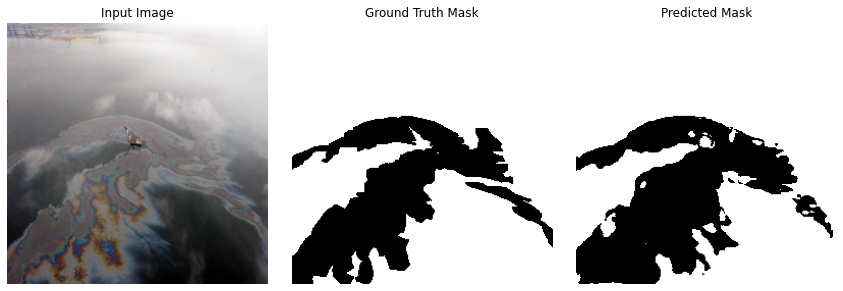

In [19]:
import matplotlib.pyplot as plt

# Iterate over validloader
for x, y in validloader:

    x = x.squeeze(0)
    y = y.squeeze(0)
    
    # Make predictions
    y_pred = model(x.unsqueeze(0)).squeeze(0)

    # Create a grid of subplots
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Plot x
    axs[0].imshow(x.permute(1, 2, 0))
    axs[0].set_title('Input Image')

    # Plot y
    axs[1].imshow(y.permute(1, 2, 0), cmap='gray')
    axs[1].set_title('Ground Truth Mask')

    # Plot predicted y
    axs[2].imshow((torch.sigmoid(y_pred.permute(1, 2, 0)) > 0.5).detach().cpu().numpy(), cmap='gray')
    axs[2].set_title('Predicted Mask')

    # Remove axis labels
    for ax in axs:
        ax.axis('off')

    # Display the subplots
    plt.tight_layout()
    plt.show()

    # Exit the loop after plotting the first sample
    break


## IOU Score Evaluation

In [13]:
iou_scores = []
for x, y in validloader:
    # Take the first sample from the batch
    x = x.squeeze(dim=0)
    y = y.squeeze(dim=0)
    
    # Make predictions
    y_pred = model(x.unsqueeze(0)).squeeze(0)
    
    z = torch.sigmoid(y_pred) > 0.5
    z = z.type(torch.int)

    for i in range(2):
        intersection = torch.logical_and(z == i, y == i).sum().item()
        union = torch.logical_or(z == i, y == i).sum().item()
        iou = intersection / union if union > 0 else 0
        iou_scores.append(iou)
print(iou_scores)
z = np.mean(iou_scores)
print(z)

KeyboardInterrupt: 

In [57]:
iou_scores = []
for x, y in validloader:
    # Take the first sample from the batch
    x = x.squeeze(dim=0)
    y = y.squeeze(dim=0)
    
    # Make predictions
    y_pred = model(x.unsqueeze(0)).squeeze(0)

    z = torch.sigmoid(y_pred) > 0.5
    z = z.type(torch.int)

    intersection = torch.logical_and(z == 0, y == 0).sum().item()
    union = torch.logical_or(z == 0, y == 0).sum().item()
    iou = intersection / union if union > 0 else 0
    iou_scores.append(iou)
print(iou_scores)
z = np.mean(iou_scores)
print(z)

[0.03429808568824066, 0.6030742437436111, 0.056167256521169225, 0.6936447232726023, 0.6013124414088656, 0.5947961940561494, 0.9256931159090219, 0.4254708217211384, 0.5925503881489922, 0.8749203265851215, 0.7115040918069796, 0.42541924095322153, 0.6223772397756805, 0.918782184479176, 0.9727613612244417, 0.9466836182644449, 0.852656494357327, 0.46489818434749236, 0.9267233179022132, 0.8811577176728166, 0.18738186795281236, 0.005626030244391887, 0.5276243093922652, 0.6344724097946934, 0.7818394108137238, 0.8615545278233627, 0.004842998227399342, 0.8584163756636288, 0.5754072308303536, 0.4262972347691969, 0.6868528455899024, 0.5834346381392334, 0.6505325136375444, 0.6742496384862272, 0.8671219202323155, 0.8492318559067632, 0.9377406016824296, 0.6232930879949385, 0.5404568852403863, 0.2161625370364341, 0.37920760697305866, 0.5745335867974362, 0.8850714650953274, 0.21140962306286798, 0.9162278941279248, 0.9087218899683381, 0.48099818654892373, 0.5429589629468246, 0.8327395501056382, 0.510606

In [59]:
iou_scores = []
for x, y in validloader:
    # Take the first sample from the batch
    x = x.squeeze(dim=0)
    y = y.squeeze(dim=0)
    
    # Make predictions
    y_pred = model(x.unsqueeze(0)).squeeze(0)
    #z = torch.sigmoid(y_pred)>0.5
    z = torch.sigmoid(y_pred) > 0.5
    z = z.type(torch.int)
    #print(z)
    #print(y)
    #for i in range(2):
    intersection = torch.logical_and(z == 1, y == 1).sum().item()
    union = torch.logical_or(z == 1, y == 1).sum().item()
    iou = intersection / union if union > 0 else 0
    iou_scores.append(iou)
print(iou_scores)
z = np.mean(iou_scores)
print(z)

[0.8877417597384909, 0.8281795053374249, 0.6094573643410852, 0.3678867079710522, 0.7344427866406519, 0.8382841676088669, 0.24627148634984833, 0.7807705482539168, 0.47480271478703884, 0.6203184784161812, 0.5775321990777548, 0.5711268252364772, 0.9252086674067678, 0.18229166666666666, 0.32341952970478355, 0.7131533496954823, 0.9026460571129159, 0.8559894640403115, 0.8553266816865143, 0.8337423760114694, 0.666163049781766, 0.8672702106168868, 0.6936096365863618, 0.6342292440360042, 0.7706333354809612, 0.7774816131102226, 0.7533381977380518, 0.9343100189035917, 0.7831283241267429, 0.7036212826218895, 0.5781396276799828, 0.6773635619960267, 0.8636114617821499, 0.9301894328426338, 0.48455133498486097, 0.7286961311919996, 0.16819398264536534, 0.8995167599907954, 0.8010245607315555, 0.6860628465804066, 0.8462188769805558, 0.9136561534115457, 0.7589132632874664, 0.878312966195842, 0.8586313953982903, 0.38833111441773044, 0.6874192715060707, 0.7698607829363305, 0.9416940171616117, 0.194143512617

0.6875918877237761


In [14]:
iou_scores = []
for x, y in trainloader:
    # Take the first sample from the batch
    x = x.squeeze(dim=0)
    y = y.squeeze(dim=0)
    
    # Make predictions
    y_pred = model(x.unsqueeze(0)).squeeze(0)
    #z = torch.sigmoid(y_pred)>0.5
    z = torch.sigmoid(y_pred) > 0.5
    z = z.type(torch.int)
    #print(z)
    #print(y)
    for i in range(2):
        intersection = torch.logical_and(z == i, y == i).sum().item()
        union = torch.logical_or(z == i, y == i).sum().item()
        iou = intersection / union if union > 0 else 0
        iou_scores.append(iou)
print(iou_scores)

[0.796790554585516, 0.640641082193795, 0.6270415628583857, 0.8101650563607086, 0.4112167942368303, 0.5891247569860377, 0.7931052172574771, 0.9194624171259685, 0.5552803492368185, 0.6982416335791265, 0.009136867492231344, 0.6730283597851207, 0.5679049181958327, 0.5929829492224096, 0.10834959032383926, 0.6358609920489492, 0.49971591917900643, 0.24642293600064186, 0.9027476107732406, 0.889054079167441, 0.7177267595031991, 0.6953778668327422, 0.5509227614490773, 0.784523671721264, 0.9779050736497545, 0.9824180594747124, 0.7924003517598217, 0.6210899589399029, 0.21915652053145687, 0.7225913621262459, 0.8158057169614541, 0.6819200940934318, 0.8944553452750174, 0.9105250449386956, 0.6035164722994871, 0.6290646039249391, 0.8173371503189192, 0.9261702732329179, 0.9642109527989736, 0.971334306885175, 0.8502384376655817, 0.9081284390889461, 0.5306244995996797, 0.8778285257801782, 0.14312612708178635, 0.462728013435541, 0.04091568261860369, 0.5683516961663377, 0.16415812390715534, 0.59868637650622